In [30]:
import pandas as pd
import pickle
import sympy
import networkx as nx
import numpy as onp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
X=10*onp.random.rand(4,5000)
Y1=X[0]*X[1]
Y2=X[1]+onp.sin(X[3])
ga=Y2
X_used=onp.concatenate([X,onp.expand_dims(Y1,axis=0)])
X=onp.concatenate([X,onp.expand_dims(Y1,axis=0),onp.expand_dims(Y2,axis=0)])
#X=X-onp.expand_dims(onp.mean(X,axis=1),axis=1)
#X_used=X_used-onp.expand_dims(onp.mean(X_used,axis=1),axis=1)
beta=onp.array([0.1,0.01,0.001])

In [55]:
def get_alpha(X,tol=1e-6):
    constant_mat=onp.ones((X.shape[1],X.shape[1]))
    linear_mat=onp.expand_dims(X,-1)*onp.expand_dims(X,1)
    quadratic_mat=onp.expand_dims(linear_mat,0)*onp.expand_dims(linear_mat,1)
    diff_X=onp.tile(onp.expand_dims(X,-1),(1,1,X.shape[1]))-onp.tile(onp.expand_dims(X,1),(1,X.shape[1],1))
    gaussian_mat=onp.exp(-(diff_X)**2/2)

    K=constant_mat+beta[0]*onp.sum(linear_mat,axis=0)+beta[1]*onp.sum(quadratic_mat,axis=(0,1))+beta[2]*onp.prod(gaussian_mat+onp.ones_like(gaussian_mat),axis=0)
    print('computing eigenvalues')
    eigenvalues,alphas = onp.linalg.eigh(K)
    print('conditionning number :',eigenvalues[-1]/eigenvalues[0])
    max_eigenval=eigenvalues[-1]

    alphas=alphas[eigenvalues/max_eigenval>tol]
    return alphas

alphas_1e8=get_alpha(X,1e-8)
alphas_1e6=get_alpha(X,1e-6)

computing eigenvalues
conditionning number : 982710926193.7883
computing eigenvalues
conditionning number : 982710926193.7883


In [71]:
constant_mat=onp.ones((X.shape[1],X.shape[1]))
linear_mat=onp.expand_dims(X,-1)*onp.expand_dims(X,1)
quadratic_mat=onp.expand_dims(linear_mat,0)*onp.expand_dims(linear_mat,1)
diff_X=onp.tile(onp.expand_dims(X,-1),(1,1,X.shape[1]))-onp.tile(onp.expand_dims(X,1),(1,X.shape[1],1))
gaussian_mat=onp.exp(-(diff_X)**2/2)

K=constant_mat+beta[0]*onp.sum(linear_mat,axis=0)+beta[1]*onp.sum(quadratic_mat,axis=(0,1))+beta[2]*onp.prod(gaussian_mat+onp.ones_like(gaussian_mat),axis=0)
print('computing eigenvalues')
eigenvalues,alphas = onp.linalg.eigh(K)

computing eigenvalues


In [121]:
eigenvalues[-10:]

array([1.76482369e+04, 2.65221969e+04, 3.04754167e+04, 5.34436744e+04,
       1.29714997e+05, 3.24697768e+05, 7.77922385e+05, 1.07747681e+06,
       2.29837047e+06, 2.36954005e+08])

In [120]:
alphas[:,-1]

array([3.40366268e-02, 4.91080437e-05, 6.51081766e-03, ...,
       2.97105009e-02, 5.92563641e-05, 2.35942721e-02])

In [116]:
onp.linalg.norm(onp.ones(5000))**2

5000.0

In [123]:
eigenvalues[eigenvalues>1e-1].shape

(581,)

In [111]:
1e-1*4500

450.0

In [110]:
onp.sum(eigenvalues[:-500])

115.77855109785003

In [109]:
eigenvalues[-500]

0.11457519114039158

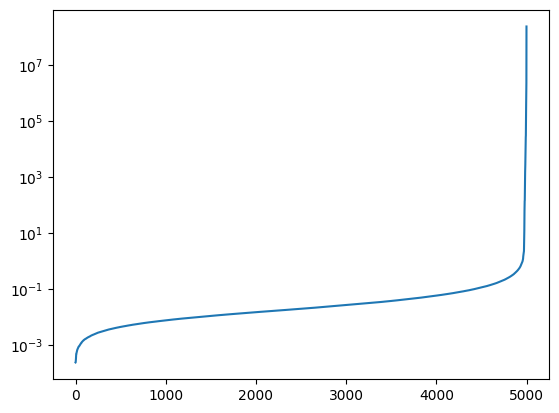

In [84]:
plt.plot(eigenvalues)
plt.yscale('log')

In [50]:
constant_mat=onp.ones((X_used.shape[1],X_used.shape[1]))
linear_mat=onp.expand_dims(X_used,-1)*onp.expand_dims(X_used,1)
quadratic_mat=onp.expand_dims(linear_mat,0)*onp.expand_dims(linear_mat,1)
diff_X=onp.tile(onp.expand_dims(X_used,-1),(1,1,X_used.shape[1]))-onp.tile(onp.expand_dims(X_used,1),(1,X_used.shape[1],1))
gaussian_mat=onp.exp(-(diff_X)**2/2)
Kl=constant_mat+beta[0]*onp.sum(linear_mat,axis=0)
Kq=Kl+beta[1]*onp.sum(quadratic_mat,axis=(0,1))
Kg=Kq+beta[2]*onp.prod(gaussian_mat+onp.ones_like(gaussian_mat),axis=0)

In [51]:
ga_alpha=alphas@ga
Kl_alpha=alphas@Kl@alphas.T
Kq_alpha=alphas@Kq@alphas.T
Kg_alpha=alphas@Kg@alphas.T






gamma=10



yb=-onp.linalg.solve(Kq+gamma*onp.eye(Kq.shape[0]),ga)
yb_alpha=-onp.linalg.solve(Kq_alpha+gamma*onp.eye(Kq_alpha.shape[0]),ga_alpha)
noise_alpha=-gamma*onp.dot(yb_alpha,yb_alpha)/onp.dot(ga_alpha,yb_alpha)
noise=-gamma*onp.dot(yb,yb)/onp.dot(ga,yb)
print(noise)
noise_alpha

0.9452311759278017


0.5800199246679884

In [56]:
def noise(K,gamma,ga):
    yb=-onp.linalg.solve(K+gamma*onp.eye(K.shape[0]),ga)
    return -gamma*onp.dot(yb,yb)/onp.dot(ga,yb)

def ga_and_Ks(alphas,k1,k2,k3,g):
    g_alpha=alphas@g
    K1=alphas@k1@alphas.T
    K2=alphas@k2@alphas.T
    K3=alphas@k3@alphas.T 
    return g_alpha,K1,K2,K3

In [92]:
gamma_list=onp.logspace(-10,10,500)
gat,klt,kqt,kgt=ga_and_Ks(alphas[-1000:],Kl,Kq,Kg,ga)
ge6,kle6,kqe6,kge6=ga_and_Ks(alphas_1e6,Kl,Kq,Kg,ga)
ge8,kle8,kqe8,kge8=ga_and_Ks(alphas_1e8,Kl,Kq,Kg,ga)
noises_l=[noise(klt,g,gat) for g in tqdm(gamma_list)]
noises_q=[noise(kqt,g,gat) for g in tqdm(gamma_list)]
noises_g=[noise(kgt,g,gat) for g in tqdm(gamma_list)]

noises_l_e6=[noise(kle6,g,ge6) for g in tqdm(gamma_list)]
noises_q_e6=[noise(kqe6,g,ge6) for g in tqdm(gamma_list)]
noises_g_e6=[noise(kge6,g,ge6) for g in tqdm(gamma_list)]
noises_l_e8=[noise(kle8,g,ge8) for g in tqdm(gamma_list)]
noises_q_e8=[noise(kqe8,g,ge8) for g in tqdm(gamma_list)]
noises_g_e8=[noise(kge8,g,ge8) for g in tqdm(gamma_list)]

100%|██████████| 500/500 [00:00<00:00, 12730.15it/s]


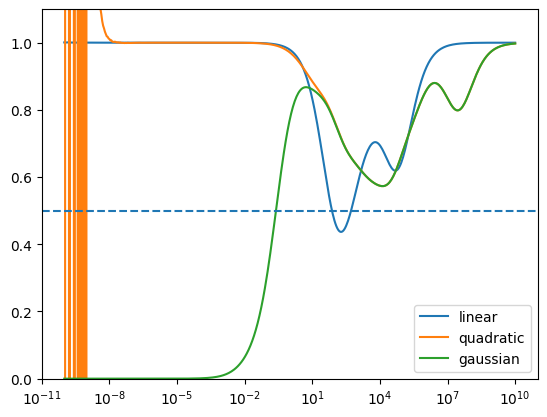

In [93]:
plt.plot(gamma_list,noises_l,label='linear')
plt.plot(gamma_list,noises_q,label='quadratic')
plt.plot(gamma_list,noises_g,label='gaussian')
plt.axhline(0.5,linestyle='--')
plt.xscale('log')
plt.legend()
plt.ylim([0,1.1])
plt.show()

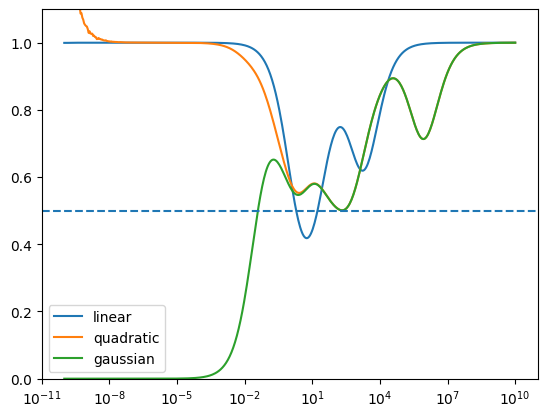

In [89]:
plt.plot(gamma_list,noises_l_e8,label='linear')
plt.plot(gamma_list,noises_q_e8,label='quadratic')
plt.plot(gamma_list,noises_g_e8,label='gaussian')
plt.axhline(0.5,linestyle='--')
plt.xscale('log')
plt.legend()
plt.ylim([0,1.1])
plt.show()

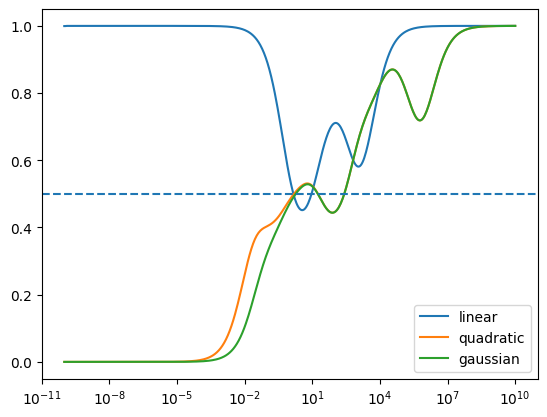

In [68]:
plt.plot(gamma_list,noises_l_e6,label='linear')
plt.plot(gamma_list,noises_q_e6,label='quadratic')
plt.plot(gamma_list,noises_g_e6,label='gaussian')
plt.axhline(0.5,linestyle='--')
plt.xscale('log')
plt.legend()
plt.show()